In [4016]:
from sympy import init_session
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.integrate as it
from scipy.signal import savgol_filter

init_session(use_latex = True)

IPython console for SymPy 1.13.2 (Python 3.10.1-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.2/



In [4017]:
# Size
a = 1.97 * 0.0254 #m R2
b = 12.4 * 0.0254 #m R3
c = 3.17 * 0.0254 #m R4
d = 13.4 * 0.0254 #m R1
a, b, c, d

In [4018]:
m = 3.48 #kg
l = 24.5 * 0.0254 #length of wiper m
I = 1/12 * m * l**2 + m * (l/2)**2 + 1/3 * m * l**2#moment of inertia about com kgm^2
mu_k = 0.3  # coefficient of kinetic friction
g = 9.81  # gravity (m/s^2)
theta = 23 #degs
n = 5 # order of polynomial filtering need to be odd number
l

In [4019]:
#Parameters
motor_torque = 30 #NM 
df = pd.read_csv("4bardata.txt", sep='\t' , header = None, names = ["time [s]", "theta_2 [rad]", "theta_3 [rad]", "theta_4 [rad]", "theta_2 [°]","theta_3 [°]","theta_4 [°]","omega_2 [rad/s]", "omega_43 [rad/s]","omega_4 [rad/s]","alpha_2 [rad/s^2]","alpha_3 [rad/s^2]","alpha_4 [rad/s^2]"])
#df.head(20)
#print(df.shape[0])
results = motor_torque * ((c * np.sin(np.deg2rad(156.133)))/ (a * np.sin(np.deg2rad(0.33))))
results2 = motor_torque * ((c * np.sin(np.deg2rad(156.133)))/ (a))
print(results2)

19.532427143362487


In [4020]:
#Torque Calculations

tau_out = []
err = 15 # to eliminate spikes and use small angle approximation
for i in range(df.shape[0]):
    theta_a = 180.0 - df["theta_2 [°]"][i] + df["theta_3 [°]"][i] # inner angle between link a and b
    theta_b = df["theta_4 [°]"][i]- df["theta_3 [°]"][i] # inner angle between link b and c
    #print(theta_a, theta_b)
    if abs(theta_a) > err and abs(theta_a) < (180-err):
    
        #print("good")
        temp1 = motor_torque * ((c * np.sin(np.deg2rad(theta_b)))/ (a * np.sin(np.deg2rad(theta_a))))
        tau_out.append(temp1)
    elif abs(theta_b) < err and abs(theta_a) > (180-err):
        temp2 = motor_torque * (c)/ (a)
        tau_out.append(temp2)
    else: 
        #print("anti bug")
        temp3 = motor_torque * (c * np.sin(np.deg2rad(theta_b)))/ (a)
        tau_out.append(temp3)

filter_tau_out = savgol_filter(tau_out, 51, n)
df["Input_Torque [nm]"] = filter_tau_out
(print(df["Input_Torque [nm]"].to_string()))

0      -76.506914
1      -54.617347
2      -40.515079
3      -32.735825
4      -29.959722
5      -31.005127
6      -34.822412
7      -40.487761
8      -47.196966
9      -54.259225
10     -61.090937
11     -67.209500
12     -72.227104
13     -75.844534
14     -77.844960
15     -78.087738
16     -76.502203
17     -73.081469
18     -67.876224
19     -60.988525
20     -52.565597
21     -42.793629
22     -31.891568
23     -20.104920
24      -7.699544
25       5.044553
26      15.417921
27      25.657497
28      35.567897
29      44.977248
30      53.721805
31      61.648481
32      68.617446
33      74.504843
34      79.205670
35      82.636904
36      84.740975
37      85.489721
38      84.889086
39      82.984966
40      79.871000
41      75.700067
42      70.703897
43      63.215319
44      56.081462
45      49.637827
46      44.353053
47      40.873020
48      40.095571
49      43.311141
50      42.161997
51      41.582263
52      38.500016
53      38.140738
54      40.006907
55      43

In [4021]:
# Equations of Motion
acceleration_t = []
force_spring = []
alpha_w = []
F_n = []
F_friction = []

for i in range(df.shape[0]):
    temp7 = (df["Input_Torque [nm]"][i]- m * g * np.cos(np.radians(theta)))/ I  #alpha
    alpha_w.append(temp7)
    
    temp8 = l * alpha_w[i] #use a = r*alpha to find tangential acceleration
    acceleration_t.append(temp8)
    
    temp9 = l * (df["Input_Torque [nm]"][i]) + m * acceleration_t[i] #friction
    F_friction.append(temp8)

    temp10 = F_friction[i] / mu_k #Normal force
    F_n.append(temp10)
    
    temp11 = F_n[i] - m * g * np.cos(np.radians(theta)) #Spring Force
    force_spring.append(temp11)
    
df["F_normal [N]"] = F_n
df["Friction [N]"] = F_friction
df["acc_tan [m/s^2]"] = acceleration_t
df["alpha_w [rad/s^2]"] = alpha_w
df["F_spring [N]"]= force_spring
df.head()

,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],alpha_2 [rad/s^2],alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_Torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N]
0,0.00,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,0.0,-10.640384,-4.887655,-76.506914,-249.195709,-74.758713,-74.758713,-120.132915,-280.620640
1,0.01,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,0.0,-10.640384,-4.887655,-54.617347,-198.656537,-59.596961,-59.596961,-95.768859,-230.081469
2,0.02,4.780489,0.380609,2.156869,273.901843,21.807267,123.579504,6.81,0.547185,-4.113627,0.0,-11.020230,-4.328158,-40.515079,-166.096873,-49.829062,-49.829062,-80.072412,-197.521804
3,0.03,4.848589,0.385524,2.115527,277.803685,22.088886,121.210765,6.81,0.435307,-4.153755,0.0,-11.345834,-3.681429,-32.735825,-148.135938,-44.440782,-44.440782,-71.413758,-179.560870
4,0.04,4.916689,0.389305,2.073817,281.705528,22.305527,118.820983,6.81,0.320474,-4.186905,0.0,-11.609664,-2.929573,-29.959722,-141.726404,-42.517921,-42.517921,-68.323833,-173.151335


In [4022]:
#Use trapezoidal rule to find v by integration
dt = 0.01
v_tan = it.cumulative_trapezoid(y = df["acc_tan [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
#v_nor = it.cumulative_trapezoid(y = df["acc_nor [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
df["vel_tan [m/s]"] = v_tan
#df["vel_nor [m/s]"] = v_nor


In [4023]:
#Use trapezoidal rule to find position by integration
dt = 0.01
tan = it.cumulative_trapezoid(y = df["vel_tan [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
#nor = it.cumulative_trapezoid(y = df["vel_nor [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
df["pos_tan [m]"] = tan
#df["pos_nor [m]"] = nor

In [4024]:
df.head()


,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],...,alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_Torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N],vel_tan [m/s],pos_tan [m]
0,0.00,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,...,-10.640384,-4.887655,-76.506914,-249.195709,-74.758713,-74.758713,-120.132915,-280.620640,0.000000,0.000000
1,0.01,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,...,-10.640384,-4.887655,-54.617347,-198.656537,-59.596961,-59.596961,-95.768859,-230.081469,-0.671778,-0.003359
2,0.02,4.780489,0.380609,2.156869,273.901843,21.807267,123.579504,6.81,0.547185,-4.113627,...,-11.020230,-4.328158,-40.515079,-166.096873,-49.829062,-49.829062,-80.072412,-197.521804,-1.218908,-0.012812
3,0.03,4.848589,0.385524,2.115527,277.803685,22.088886,121.210765,6.81,0.435307,-4.153755,...,-11.345834,-3.681429,-32.735825,-148.135938,-44.440782,-44.440782,-71.413758,-179.560870,-1.690258,-0.027358
4,0.04,4.916689,0.389305,2.073817,281.705528,22.305527,118.820983,6.81,0.320474,-4.186905,...,-11.609664,-2.929573,-29.959722,-141.726404,-42.517921,-42.517921,-68.323833,-173.151335,-2.125051,-0.046435


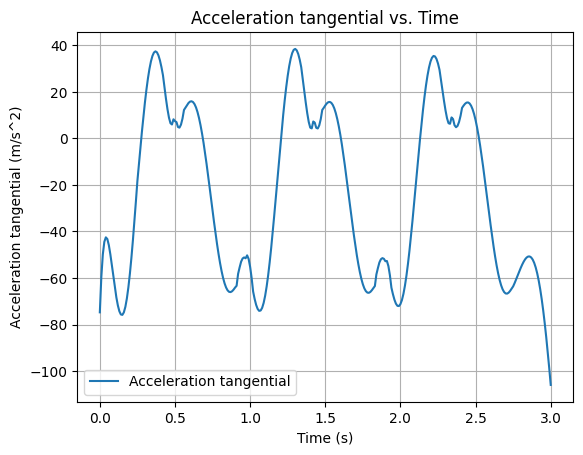

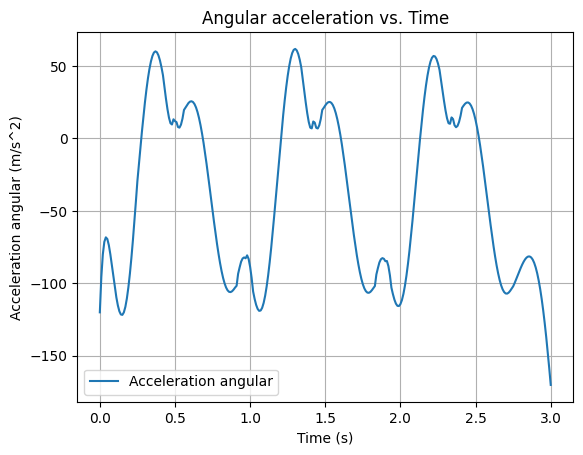

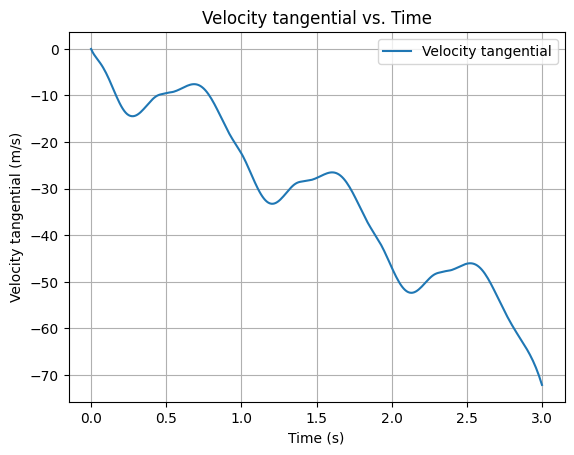

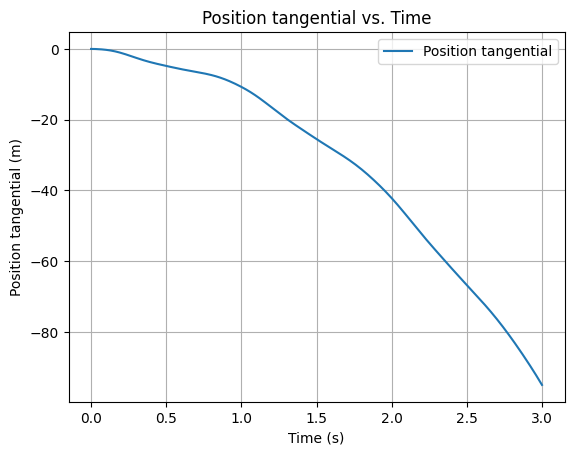

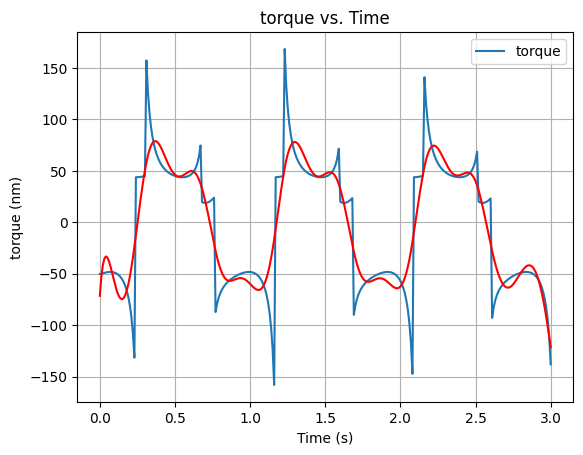

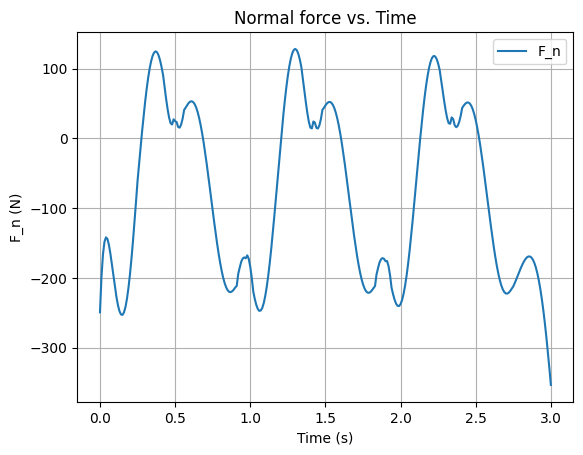

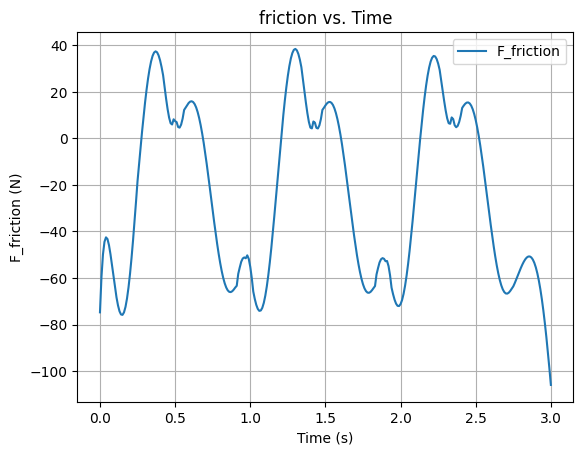

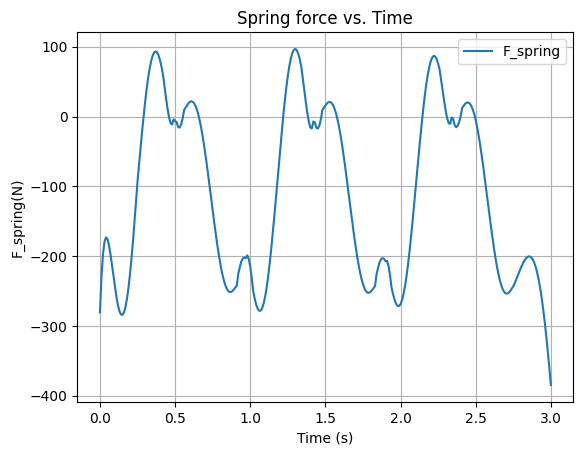

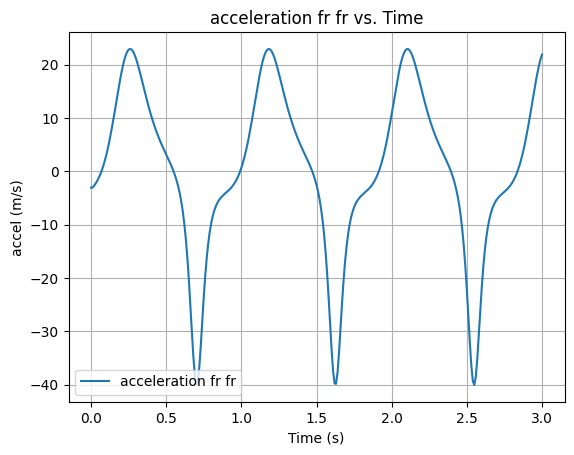

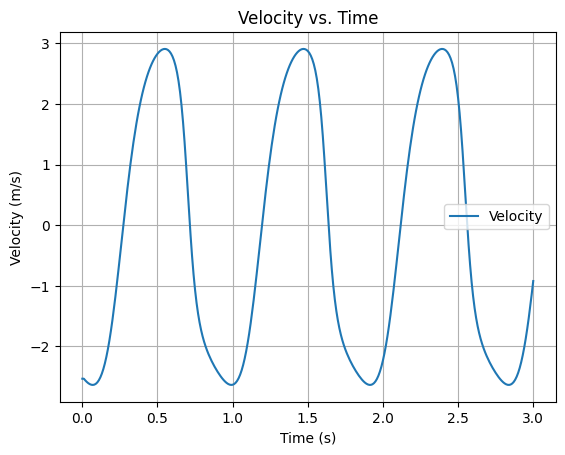

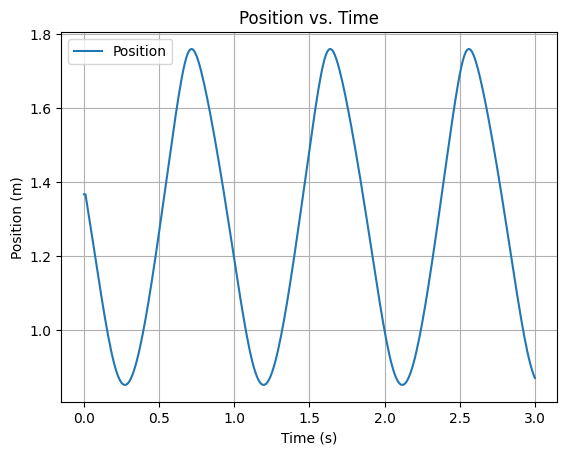

In [4025]:
# Plotting the graphs

plt.plot(df["time [s]"], df["acc_tan [m/s^2]"], label='Acceleration tangential')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration tangential (m/s^2)')
plt.title('Acceleration tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["alpha_w [rad/s^2]"], label='Acceleration angular')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration angular (m/s^2)')
plt.title('Angular acceleration vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["vel_tan [m/s]"] , label='Velocity tangential')
plt.xlabel('Time (s)')
plt.ylabel('Velocity tangential (m/s)')
plt.title('Velocity tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_tan [m]"] , label='Position tangential')
plt.xlabel('Time (s)')
plt.ylabel('Position tangential (m)')
plt.title('Position tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], tau_out, label='torque')
plt.xlabel('Time (s)')
plt.ylabel('torque (nm)')
plt.title('torque vs. Time')
plt.legend()
plt.grid()
yhat = savgol_filter(df["Input_Torque [nm]"], 51, n) # window size 51, polynomial order 3
plt.plot(df["time [s]"],yhat, color = 'red')
plt.show()


plt.plot(df["time [s]"], df["F_normal [N]"], label='F_n')
plt.xlabel('Time (s)')
plt.ylabel('F_n (N)')
plt.title('Normal force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["Friction [N]"], label='F_friction')
plt.xlabel('Time (s)')
plt.ylabel('F_friction (N)')
plt.title('friction vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_spring [N]"], label='F_spring')
plt.xlabel('Time (s)')
plt.ylabel('F_spring(N)')
plt.title('Spring force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["alpha_4 [rad/s^2]"], label='acceleration fr fr')
plt.xlabel('Time (s)')
plt.ylabel('accel (m/s)')
plt.title('acceleration fr fr vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["omega_4 [rad/s]"], label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["theta_4 [rad]"], label='Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position vs. Time')
plt.legend()
plt.grid()
plt.show()